In [317]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from os import listdir

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve


from main import df_scrolling_object

import my_func
import importlib
# importlib.reload(main)
importlib.reload(my_func)

from pandas_profiling import ProfileReport

In [318]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [319]:
input_folder = 'input/'
listdir(input_folder)

[&#39;train.csv&#39;]

| Столбец        |     Значение                    |
|:---------------|:--------------------------------|
|client_id	     |    идентификатор клиента        |  
|education	     |   уровень образования           | 
|sex	         | пол заёмщика  
|age             |	возраст заёмщика  
|car	         |флаг наличия автомобиля  
|car_type	     |флаг автомобиля-иномарки  
|decline_app_cnt |	количество отказанных прошлых заявок  
|good_work       |	флаг наличия «хорошей» работы  
|bki_request_cnt |	количество запросов в БКИ  
|home_address	 |категоризатор домашнего адреса  
|work_address	 |категоризатор рабочего адреса  
|income	         |доход заёмщика  
|foreign_passport|	наличие загранпаспорта  
|sna | связь заемщика с клиентами банка
|first_time | давность наличия информации о заемщике
|score_bki | скоринговый балл по данным из БКИ
|region_rating | рейтинг региона
|app_date | дата подачи заявки
|default	     |наличие дефолта  

In [320]:
data_train = pd.read_csv('kaggle/train.csv')
data_subm = pd.read_csv('kaggle/sample_submission.csv')
data_test = pd.read_csv('kaggle/test.csv')
data_train['train'] = 1 # помечаем где у нас трейн
data_test['train'] = 0 # помечаем где у нас тест
data = data_train.append(data_test, sort=False).reset_index(drop=True)

In [321]:
bin_cols = ['good_work', 'foreign_passport', 'car', 'car_type', 'sex' ]
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
cat_cols = ['education', 'home_address' , 'work_address', 'first_time', 'sna' , 'region_rating']

In [322]:
# переведем признак data.score_bki к положительным значениям, чтобы проще можно было логорифмировать
data.score_bki = data.score_bki - data.score_bki.min() 

In [323]:
edu_income_rel = dict({'SCH': list([0, 31960.275039]),
                       'UGR': list([31960.275039,39391.796251]),
                       'GRD': list([39391.796251, 54663.948941]),
                       'PGR': list([54663.948941, 77548.206046]),
                       'ACD': list([77548.206046, 999999999999])})
def fill_edu(income, edu_income_rel):
    for edu, income_edu in edu_income_rel.items():
         if income_edu[0] < income <  income_edu[1]:
             return edu
na_index = data[data.education.isna()].index
data.loc[data['education'].isna(), 'education'] = data[data.education.isna()].income.apply(lambda x: fill_edu(x, edu_income_rel))

### Собираем дату

In [324]:
data.app_date = pd.to_datetime(data.app_date)
data['month'] = data.app_date.dt.month
data['day'] = data.app_date.dt.day
data['year'] = data.app_date.dt.year
last_date = set()
data['app_date_diff_today'] = pd.datetime.today() - data.app_date
data['app_date_diff_today'] = data['app_date_diff_today'].dt.days
data.drop(['app_date'], axis=1, inplace=True)

# ВЫБРОСЫ !!!!!!!   
Все нумерные признаки оставляем с выбросами, как таковые выбросы были   
обнаружены в колонке дохода, но для любого сокращенного диапазона по этому признаку   
скор падает

# Образование

In [325]:
edu_dict = dict({'SCH': 0, #school
                 'GRD': 1, #out-student
                 'UGR': 2, #student
                 'PGR': 3, #aspirant
                 'ACD': 4})#academic 
data['education'] = data['education'].map(edu_dict)

# PROFILER

In [326]:
# profile = ProfileReport(data)
# profile.to_widgets()

# Кодируем бинарные признаки

In [327]:
label_encoder = LabelEncoder()

for bin_col in bin_cols:
    data[bin_col] = label_encoder.fit_transform(data[bin_col])

# НОВЫЕ!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [328]:
data['region_firstt'] = data['region_rating'] / (data['first_time'])
data['age_first'] = data['age'] - data['first_time'] 
data['sna_age'] =  data['age'] * data['sna'] 
data['age_eduaction'] = data['age'] / (data['education']+1 )
data['age_foreign_pass'] = data['age'] / data['foreign_passport'].apply(lambda x: 1/1.1 if x==1 else 1.1)
data['age_good_work'] = data['age'] / data['good_work'].apply(lambda x: 1/1.2 if x==1 else 1.2)

data['sna_age'] =  data['age'] * data['sna'] 
data['work_adr_age'] = data['age'] / data['work_address']
data['bki_cnt_word_adr'] = data['bki_request_cnt'] / data['work_address']
data['score_bki_work_adr'] = data['score_bki'] - data['work_address']
data['bki_cnt_first_time'] = data['bki_request_cnt'] * data['first_time']
data['region_age'] = data['age'] * (data['decline_app_cnt'])

new_num_cols = ['sna_age' , 'age_eduaction', 'age_foreign_pass', 'age_good_work']

# добавим новый признак к списку категорий, чтобы он попал на логарифмирование и стандартизацию
num_cols = num_cols + ['region_firstt'] #+ ['work_adr_age']

# Определение важности признаков

In [329]:
label_encoder = LabelEncoder()

for bin_col in bin_cols:
    data[bin_col] = label_encoder.fit_transform(data[bin_col])

# data.education = data.education.astype('category').cat.codes

&lt;AxesSubplot:&gt;

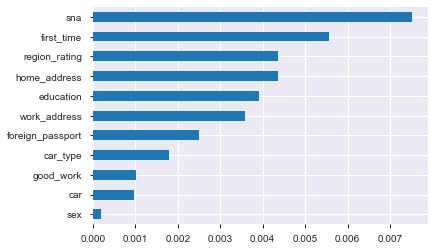

In [330]:
data_cat = data[data.train==1].copy()
imp_cat = Series(mutual_info_classif(data_cat[bin_cols + cat_cols], data_cat['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [331]:
data = pd.get_dummies(data, columns=cat_cols, drop_first=False)

In [332]:
cat_cols

[&#39;education&#39;,
 &#39;home_address&#39;,
 &#39;work_address&#39;,
 &#39;first_time&#39;,
 &#39;sna&#39;,
 &#39;region_rating&#39;]

In [333]:
data[num_cols] = data[num_cols].apply(lambda x: np.log(x + 1))

In [334]:
# Стандартизация числовых переменных

data[num_cols] = StandardScaler().fit_transform(data[num_cols].values)

In [335]:
import main
from main import df_scrolling_object
import importlib
importlib.reload(main)

# data_obj = df_scrolling_object(data)
# X, Y = data_obj.return_XY()

X = data[data.train==1].drop(['default'], axis=1)
Y = data[data.train==1]['default']
subm_client_id = data[data.train==0]['client_id']

In [336]:
from sklearn.feature_selection import RFE
C = 1
penalty = 'l1'
solver = 'liblinear'

estimator = LogisticRegression(C=C, penalty=penalty, solver = solver,  random_state=RANDOM_SEED)
selector = RFE(estimator, n_features_to_select=50, step=1)
selector = selector.fit(X, Y)

X = selector.transform(X)

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

In [338]:
X.shape

(73799, 50)

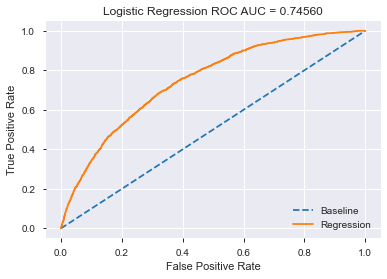

roc_auc=0.745602  C=1.9463099813601865   penalty=l2 solver=newton-cg
[[12874    59]
 [ 1781    46]]


In [339]:
# C = 1
# penalty = 'l2'
# solver = 'newton-cg'

# C = 1.4813022192790921
# penalty = 'l1'
# solver = 'liblinear'

C = 1.9463099813601865
penalty = 'l2'
solver = 'newton-cg'

model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
print(confusion_matrix(y_test, y_pred))

In [340]:
# X_test = data[data.train==0].drop('default', axis=1)
# X_test = selector.transform(X_test)
# y_pred_subm = model.predict_proba(X_test)[:,1]

# submit = pd.DataFrame(subm_client_id)
# submit['default'] = y_pred_subm
# submit.to_csv('submission.csv', index=False)

In [341]:
X_test.shape

(14760, 50)

roc_auc=0.745602  C=1.9463099813601865   penalty=l2 solver=newton-cg  
roc_auc=0.745533 C=1 penalty=l1 solver=liblinear RFE=50    
roc_auc=0.745533  C=1   penalty=l1 solver=liblinear RFE=52  
roc_auc=0.745415  C=1   penalty=l1 solver=liblinear scorbki forpassp 1 1.2  
roc_auc=0.74549  C=1   penalty=l1 solver=liblinear age / decl cnt  
roc_auc=0.745474  C=1   penalty=l1 solver=liblinear age / region  
roc_auc=0.745405  C=1   penalty=l1 solver=liblinear  first_time x bki cnt  
roc_auc=0.745265  C=1   penalty=l1 solver=liblinear  scor bki - work addr    
roc_auc=0.744641  C=1   penalty=l1 solver=liblinear  scor bki + work addr  
roc_auc=0.745155  C=1   penalty=l1 solver=liblinear
roc_auc=0.745079  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744978  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744955  C=1   penalty=l1 solver=liblinear  + age ~ foreign pass(1.1)  
roc_auc=0.744949  C=1   penalty=l1 solver=liblinear  + age ~ foreign pass(1.2)  
roc_auc=0.744922  C=1   penalty=l1 solver=liblinear  + age ~ foreign pass(1.4)  
roc_auc=0.744845  C=1   penalty=l1 solver=liblinear  + age/ edu  nonlog  
roc_auc=0.744803  C=1   penalty=l1 solver=liblinear  + age* edu  nonlog  
roc_auc=0.744673  C=1   penalty=l1 solver=liblinear  + sna*age  nonlog  
roc_auc=0.744571  C=1   penalty=l1 solver=liblinear  + sna/age  nonlog  
roc_auc=0.744213  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744213  C=1   penalty=l1 solver=liblinear  
roc_auc=0.744709  C=1   p enalty=l2 solver=newton-cg  
roc_auc=0.744682  C=1   penalty=l2 solver=newton-cg  
roc_auc=0.744641  C=1   penalty=l2 solver=newton-cg   
roc_auc=0.744112 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.744088 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.743984 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.7439 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.743433 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.677348  
roc_auc=0.677304  
roc_auc=0.677311 C=1 penalty=l2 solver=newton-cg  
roc_auc=0.677277 C=2.7825594022071245 penalty=l2 solver=  

In [355]:
### HyperOpt Parameter Tuning
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin

N_FOLDS = 5
MAX_EVALS = 50

def objective(params, n_folds = N_FOLDS):
    """Objective function for Logistic Regression Hyperparameter Tuning"""

    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC

    clf = LogisticRegression(random_state=RANDOM_SEED, verbose =0)
    scores = cross_val_score(clf, X, Y, cv=5, scoring='roc_auc')

    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'warm_start' : hp.choice('warm_start', [True, False]),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'tol' : hp.uniform('tol', 0.00001, 0.0001),
    'C' : hp.uniform('C', 0.05, 3),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000)),
    'penalty' : hp.choice('penalty', ['l1' , 'l2'])
}

In [356]:
# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
rstate = np.random.RandomState(RANDOM_SEED)
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials, 
rstate=rstate)

100%|██████████| 50/50 [01:52&lt;00:00,  2.26s/trial, best loss: 0.2918704229724486]


In [357]:
best

{&#39;C&#39;: 1.4813022192790921,
 &#39;class_weight&#39;: 1,
 &#39;fit_intercept&#39;: 1,
 &#39;max_iter&#39;: 642,
 &#39;penalty&#39;: 0,
 &#39;solver&#39;: 2,
 &#39;tol&#39;: 2.3352574146813767e-05,
 &#39;warm_start&#39;: 1}

In [358]:
# C = 1.9463099813601865
# penalty = 'l2'
# solver = 'newton-cg'

# model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=RANDOM_SEED)
# model.fit(X_train, y_train)

# probs = model.predict_proba(X_test)
# y_pred = model.predict(X_test)
# probs = probs[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))

roc_auc=0.745602  C=1.9463099813601865   penalty=l2 solver=newton-cg  
roc_auc=0.745533 C=1 penalty=l1 solver=liblinear RFE=50  

In [359]:
# from sklearn.model_selection import GridSearchCV
# # Добавим типы регуляризации
# penalty = ['l1', 'l2']
# # Зададим ограничения для параметра регуляризации
# C = np.logspace(0, 4, 10)
# # solver
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# # Score
# scoring = {'AUC': 'roc_auc'}

# # Добавим типы регуляризации
# iter_ = 50
# epsilon_stop = 1e-3

# # Создадим гиперпараметры
# # hyperparameters = dict(C=C, penalty=penalty, solver=solver)

# hyperparameters = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs', 'newton-cg'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]

# model = LogisticRegression()
# # model.fit(X_train, y_train)

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0,  scoring=scoring, refit='AUC')

# best_model = clf.fit(X_train, y_train)

# # View best hyperparameters
# print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
# print('Лучшее Solver:', best_model.best_estimator_.get_params()['solver'])

In [360]:
# y_best_prob = best_model.predict_proba(X_test)

# probs = y_best_prob[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))

In [361]:
X.shape

(73799, 50)

roc_auc=0.745585  C=1   penalty=l1 solver=liblinear RFE = 52  
roc_auc=0.74549  C=1   penalty=l1 solver=liblinear  RFE = 53  
roc_auc=0.745548  C=1   penalty=l1 solver=liblinear RFE=50    
roc_auc=0.744915  C=1   penalty=l1 solver=liblinear RFE=35  
roc_auc=0.745453  C=1   penalty=l1 solver=liblinear RFE=40  
roc_auc=0.745415 C=1 penalty=l1 solver=liblinear FULL X

In [362]:
# # Добавим 
# iter_ = 50
# epsilon_stop = 1e-3

# # Создадим гиперпараметры
# hyperparameters = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]

# model = LogisticRegression()

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, scoring='f1', cv=5, verbose=0, refit='f1')

# clf.fit(X_train, y_train)
# model_2 = clf.best_estimator_

# # View best hyperparameters
# print('Лучшее Penalty:', model_2.get_params()['penalty'])
# print('Лучшее C:', model_2.get_params()['C'])
# print('Лучшее Solver:', model_2.get_params()['solver'])

In [363]:
# y_best_prob = model_2.predict_proba(X_test)

# probs = y_best_prob[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))

Лучшее Penalty: l1
Лучшее C: 1291.5496650148827
Лучшее Solver: liblinear

In [364]:
# # The scorers can be either be one of the predefined metric strings or a scorer
# # callable, like the one returned by make_scorer  



# from sklearn.metrics import make_scorer
# from sklearn.metrics import accuracy_score, f1_score
# scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(f1_score)}
# hyperparameters = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]
# # Setting refit='AUC', refits an estimator on the whole dataset with the
# # parameter setting that has the best cross-validated AUC score.
# # That estimator is made available at ``gs.best_estimator_`` along with
# # parameters like ``gs.best_score_``, ``gs.best_params_`` and
# # ``gs.best_index_``
# model = LogisticRegression()

# gs = GridSearchCV(model,
#                   param_grid=hyperparameters,
#                   scoring=scoring, refit='AUC', return_train_score=True)
# gs.fit(X_train, y_train)

# results = gs.cv_results_
# model_3 = gs.best_estimator_

In [365]:
# print('Лучшее Penalty:', gs.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', gs.best_estimator_.get_params()['C'])
# print('Лучшее Solver:', gs.best_estimator_.get_params()['solver'])

In [366]:
# model_3 = gs.best_estimator_

In [367]:
# y_best_prob = model_3.predict_proba(X_test)

# probs = y_best_prob[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))